In [379]:
import json
import random
import networkx as nx
import matplotlib.pyplot as plt

In [380]:
def load_config(config_file):
    with open(config_file, 'r') as f:
        return json.load(f)

In [381]:
nid = 0
def _generate_edges(G, action_nodes, prob_multiple_children=0.5, level = 0):
    global nid
    nid += 1
    num_children = min(1 if level == 0 else 0, len(action_nodes) - 1)
    if random.random() < prob_multiple_children - min(0.5, level * 0.2) and len(action_nodes) > 1:
        num_children = random.randint(1, min(3, len(action_nodes) - 1))
    print(f"{nid=} {num_children=} {len(action_nodes)=} {prob_multiple_children - min(0.5, level * 0.2)}")
    actions_used = 1
    last_actions = []
    if num_children == 1:
        print(f"add edge ({action_nodes[0]}, {action_nodes[actions_used]})")
        G.add_edge(action_nodes[0], action_nodes[actions_used], dependency="completion")
        last_actions.append(action_nodes[actions_used-1])
    else:
        for i in range(num_children):
            if i == num_children -1:
                remaining_actions = action_nodes[actions_used:]
            else:
                remaining_actions = action_nodes[actions_used:-(num_children-i-1)]
            print(f"add edge ({action_nodes[0]}, {action_nodes[actions_used]})")
            G.add_edge(action_nodes[0], action_nodes[actions_used], dependency="completion")
            action_count = _generate_edges(G, remaining_actions, level=level + 1)
            actions_used += action_count
            last_actions.append(action_nodes[actions_used-1])

    print(len(action_nodes[actions_used:]))
    if len(action_nodes[actions_used:]) > 0:
        for last_action in last_actions:
            print(f"add edge ({last_action}, {action_nodes[actions_used]})")
            G.add_edge(last_action, action_nodes[actions_used], dependency="completion")
        action_count = _generate_edges(G, action_nodes[actions_used:], level=level)
        actions_used += action_count
    return actions_used

def generate_routine_graph(devices, actions_per_device, complex_dependencies=False, prob_multiple_children=0.5, non_completion_dependencies_ratio=0.5):
    """Generates a graph for a routine that includes multiple devices and actions per device."""
    G = nx.DiGraph()
    action_nodes = []
    count = 0

    # Add actions from all devices
    for device, actions in actions_per_device.items():
        device_actions = [f"{count+i}" for i, action in enumerate(actions)]
        action_nodes.extend(device_actions)
        count += len(actions)
        G.add_nodes_from(device_actions)

    if complex_dependencies:
        _generate_edges(G, action_nodes)
        # for i in range(len(action_nodes) - 1):
        #     remaining_actions = len(action_nodes) - i - 1
        #     num_children = 1
        #     # Ensure there are enough remaining actions to create multiple children
        #     if random.random() < prob_multiple_children and remaining_actions > 1:
        #         num_children = random.randint(2, min(3, remaining_actions))  # Ensure we don't exceed remaining actions

        #     # Ensure no two actions on the same device can run at the same time
        #     for j in range(1, num_children + 1):
        #         action_device = action_nodes[i].split(':')[0]  # Extract device from action
        #         next_action_device = action_nodes[i + j].split(':')[0]  # Extract device from next action

        #         if action_device == next_action_device:
        #             dependency_type = 'completion'  # Enforce completion-based dependency if same device
        #         else:
        #             if random.random() < non_completion_dependencies_ratio:
        #                 dependency_type = random.choice(['ack', 'start'])
        #             else:
        #                 dependency_type = 'completion'
        #         G.add_edge(action_nodes[i], action_nodes[i + j], dependency=dependency_type)
    else:
        for i in range(len(action_nodes) - 1):
            G.add_edge(action_nodes[i], action_nodes[i + 1], dependency='completion')

    return G

In [382]:
def generate_routines_for_space(smart_space, device_actions, scale_constraints, config_constraints):
    """Generates a routine graph for multiple devices and actions per device."""
    routine_graphs = {}
    total_routines = 0
    max_actions = scale_constraints.get("max_actions", 5)
    max_routines = scale_constraints.get("max_routines", 3)

    # Extract the configurable constraints from the config file
    use_complex_dependencies = config_constraints.get('use_complex_dependencies', True)
    prob_multiple_children = config_constraints.get('probability_multiple_children', 0.5)
    non_completion_dependencies_ratio = config_constraints.get('non_completion_dependencies_ratio', 0.5)
    high_action_routine_percentage = config_constraints.get('high_action_routine_percentage', 0.3)  # Default 30%

    required_high_action_routines = int(high_action_routine_percentage * max_routines)
    high_action_threshold = int(0.9 * max_actions)  # 90% of max_actions
    high_action_routines_count = 0

    for routine_id in range(max_routines):

        devices_in_routine = []
        for device_type, num_devices in smart_space["device_types"].items():
            devices_in_routine.extend([f"{device_type}.{i}" for i in range(num_devices)])
        devices_in_routine = random.sample(devices_in_routine, random.randint(1, len(devices_in_routine)))
        actions_per_device = {}

        for device in devices_in_routine:
            device_id = device.split('.')[0]
            available_actions = device_actions[device_id]
            num_actions = random.randint(1, min(len(available_actions), max_actions))
            actions_per_device[device] = random.sample(available_actions, num_actions)

        routine_graph = generate_routine_graph(
            devices_in_routine, actions_per_device,
            complex_dependencies=use_complex_dependencies,
            prob_multiple_children=prob_multiple_children,
            non_completion_dependencies_ratio=non_completion_dependencies_ratio
        )
        routine_graphs[f"routine_{routine_id}"] = routine_graph
        total_routines += 1
        break

    return routine_graphs

In [383]:
def generate_routines_for_smart_spaces(config_file):
    """Generates a set of routine graphs for each smart space."""
    config = load_config(config_file)
    smart_spaces = config["smart_spaces"]
    device_actions = config["device_actions"]
    config_constraints = config.get("constraints", {})

    space_routines = {}

    for space_name, space_info in smart_spaces.items():
        routines = generate_routines_for_space(space_info, device_actions, space_info["scale_constraints"], config_constraints)
        space_routines[space_name] = routines
        break

    return space_routines

In [384]:
def visualize_routine_graph(graph, device_name, space_name):
    """Visualizes the graph of a single device routine."""
    plt.figure(figsize=(12, 8))

    for layer, nodes in enumerate(nx.topological_generations(graph)):
        # `multipartite_layout` expects the layer as a node attribute, so add the
        # numeric layer value as a node attribute
        for node in nodes:
            graph.nodes[node]["layer"] = layer
    pos = nx.multipartite_layout(graph, subset_key="layer")
    edge_labels = nx.get_edge_attributes(graph, 'dependency')
    nx.draw(graph, pos, with_labels=True, node_color='lightblue', node_size=2000, font_size=10, font_weight='bold')
    # nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)
    plt.title(f"Routine Graph for {device_name} in {space_name}")
    plt.show()

In [385]:
config_file = 'routines_config.json'
space_routines = generate_routines_for_smart_spaces(config_file)

nid=1 num_children=1 len(action_nodes)=7 0.5
add edge (0, 1)
6
add edge (0, 1)
nid=2 num_children=3 len(action_nodes)=6 0.5
add edge (1, 2)
nid=3 num_children=0 len(action_nodes)=3 0.3
2
nid=4 num_children=0 len(action_nodes)=2 0.3
1
nid=5 num_children=0 len(action_nodes)=1 0.3
0
add edge (1, 5)
nid=6 num_children=0 len(action_nodes)=1 0.3
0
add edge (1, 6)
nid=7 num_children=0 len(action_nodes)=1 0.3
0
0


Generated routines for apartment:


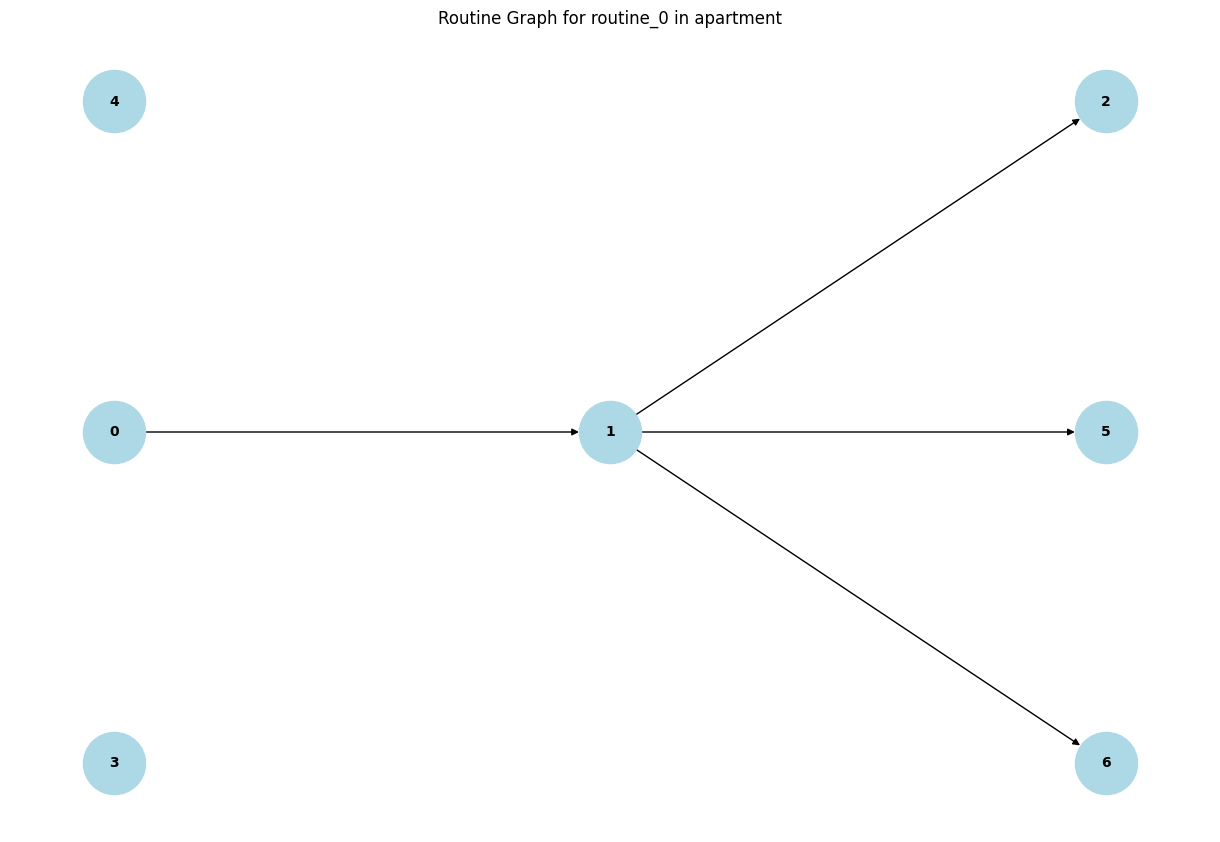

In [386]:
import uuid
from networkx import bfs_layers
import yaml

def _create_routine_script(routine_graph, node):
    actions = []
    if isinstance(node, dict):
        children = node["parallel"]
        parallel = []
        for child in children:
            child_actions = _create_action_script(routine_graph, child)
            if len(child_actions) > 1:
                parallel.append({
                    "sequence": child_actions
                })
            else:
                parallel.append(child_actions[0])
        action = {
            "parallel": parallel
        }
        actions.append(action)
    else:
        actions.extend(_create_action_script(routine_graph, node))

    return actions

def _create_action_script(routine_graph, node, is_merge_node = False):
    # edge_labels = nx.get_edge_attributes(routine_graph, 'dependency')
    actions = []
    parents = list(routine_graph.predecessors(node))
    for parent in parents:
        edge_key = f"('{parent}', '{node}')"

    if not is_merge_node and len(parents) > 1:
        return actions
    children = list(routine_graph.successors(node))
    entity, action = node.split(":")
    device_type, i = entity.split(".")
    if device_type in ("dryer", "toaster", "sprinkler", "mower", "dishwasher", "coffee_machine", "oven", "washer", "microwave"):
        action_script = {
            "service": "timer.start",
            "data": {
                "type": action
            },
            "target": {
                "entity_id": f"timer.{space_name}_{device_type}_{i}",
            }
        }
    elif device_type in ("shade", "window", "door"):
        action_script = {
            "service": f"cover.{action}",
            "target": {
                "entity_id": f"cover.{space_name}_{device_type}_{i}",
            }
        }
    elif device_type == "thermostat":
        action_script = {
            "service": f"climate.{action}",
            "target": {
                "entity_id": f"climate.{space_name}_{device_type}_{i}",
            }
        }
    else:
        action_script = {
            "service": f"{device_type}.{action}",
            "target": {
                "entity_id": f"{device_type}.{space_name}_{device_type}_{i}",
            }
        }
    actions.append(action_script)
    if len(children) > 1:
        parallel = []
        merge_node = None
        for child in children:
            child_actions = _create_action_script(routine_graph, child)
            print(f"{child=} {child_actions=}")
            if len(child_actions) > 1:
                parallel.append({
                    "sequence": child_actions
                })
            else:
                parallel.append(child_actions[0])


            if merge_node is None:
                merge_node = child_actions[-1]
        next_action = {
            "parallel": parallel
        }
        actions.append(next_action)

        if merge_node is not None:
            actions.append(_create_action_script(routine_graph, merge_node, True))
    elif len(children) == 1:
        next_action = _create_action_script(routine_graph, children[0])
        actions.extend(next_action)
    return actions

generated_routines = []
for space_name, routines in space_routines.items():
    print(f"Generated routines for {space_name}:")
    for device_name, routine_graph in routines.items():
        visualize_routine_graph(routine_graph, device_name, space_name)
        # sources = [x for x in routine_graph.nodes() if routine_graph.in_degree(x)==0]
        # if len(sources) > 1:
        #     source = {"parallel": sources}
        # else:
        #     source = sources[0]

        # actions = _create_routine_script(routine_graph, source)

        # routine = {
        #     'id': uuid.uuid4().hex,
        #     'alias': f'{space_name}_{device_name}',
        #     'description': '',
        #     'trigger': [],
        #     'action': actions,
        #     "mode": "single"
        # }
        # generated_routines.append(routine)
        break
    break

yaml.dump(generated_routines, open(f"generated_routines.yaml", "w"))